Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [2]:
# deJPEG 
fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

In [3]:
import torchgeometry as tgm
from skimage.transform import rescale, resize
def crop_rsz(image,bbox):
    sz1= image.shape[1]
    sz2= image.shape[2]
    print(image.shape)
    img_cropped = image[:,bbox[0]:bbox[2],bbox[1]:bbox[3]]
    img_cropped = resize(img_cropped.transpose(1,2,0), (sz1, sz2),anti_aliasing=True).transpose(2,0,1)
    return img_cropped


def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    duration = time.time() - startTime_for_tictoc
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(duration) + " seconds.")
    else:
        print("Toc: start time not set")
    return duration

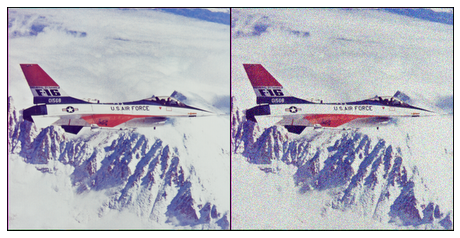

(3, 512, 512)


In [4]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    bbox = [1,1,100,100]

    img_cropped = crop_rsz(img_np,bbox)
    
    if PLOT:
        plot_image_grid([img_np,img_cropped], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False
print(img_np.shape)

# Setup

In [5]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    


elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    num_iter = 1500
    input_depth = 3 
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False
# num_iter = 2400
# input_depth = 3
# figsize = 5 
# net = skip(
#             input_depth, 3, 
#             num_channels_down = [8, 16,  32, 64], 
#             num_channels_up   = [8, 16, 32, 64],
#             num_channels_skip = [0, 0, 4, 4], 
#             upsample_mode='bilinear',
#             need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)
#net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()


# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)



Number of params: 2184307


In [6]:
print(img_pil.size)
if fname == 'data/denoising/F16_GT.png':
    net_input=img_noisy_torch
else:
    img_bicubic_pil = img_pil.resize((img_pil.size[0]*2,img_pil.size[1]*2), Image.BICUBIC)
    img_bicubic_np = pil_to_np(img_bicubic_pil)
    KERNEL_TYPE='lanczos2'
    from models.downsampler import Downsampler
    downsampler = Downsampler(n_planes=3, factor=2, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)
    # net_input =img_noisy_torch.clone()
    net_input = torch.from_numpy(img_bicubic_np).type(dtype)
if net_input.dim()<4:
    net_input=net_input.unsqueeze(0)
net_input_saved = net_input.detach().clone()

(512, 512)


In [7]:
def _init_dcvx_parameters(net_to_dcvx):
    # parameters = [p for p in self.image_net.named_parameters()] + \
    #              [p for p in self.mask_net.named_parameters()]
    #     net_to_dcvx = [self.left_net,self.right_net]
    # if self._is_learning_ambient():
    #     net_to_dcvx.append(self.ambient_net)

    # set_trace()
    parameters = list()
    for net in net_to_dcvx:
        # for name, p  in net.named_parameters():
        #     print(name, end=' ')
        layer_id = 0
        # set_trace()
        for name, p  in net.named_parameters():
            layer_id +=1
            if "weight" in name and layer_id>7 and p.dim()>1:
                parameters.append(p)
                print(name)
    return parameters

def dcvx(parameters):
    neg_weight_reg  = 0.0 
    #parameters =self.dcvx_parameters
    for p in parameters:
        neg_weight_reg += torch.norm(p[p<0])
    return neg_weight_reg

dcvx_ = 1
dcvx_coeff= 0.000005
# if 'lib' in img_path:
#     dcvx_coeff= 0.00002
parameters = _init_dcvx_parameters([net])
stop_dcvx = 0

1.1.4.1.weight
1.1.7.1.0.1.1.weight
1.1.7.1.1.1.1.weight
1.1.7.1.1.4.1.weight
1.1.7.1.1.7.1.0.1.1.weight
1.1.7.1.1.7.1.1.1.1.weight
1.1.7.1.1.7.1.1.4.1.weight
1.1.7.1.1.7.1.1.7.1.0.1.1.weight
1.1.7.1.1.7.1.1.7.1.1.1.1.weight
1.1.7.1.1.7.1.1.7.1.1.4.1.weight
1.1.7.1.1.7.1.1.7.1.1.7.1.0.1.1.weight
1.1.7.1.1.7.1.1.7.1.1.7.1.1.1.1.weight
1.1.7.1.1.7.1.1.7.1.1.7.1.1.4.1.weight
1.1.7.1.1.7.1.1.7.1.1.7.3.1.weight
1.1.7.1.1.7.1.1.7.1.1.7.6.1.weight
1.1.7.1.1.7.1.1.7.3.1.weight
1.1.7.1.1.7.1.1.7.6.1.weight
1.1.7.1.1.7.3.1.weight
1.1.7.1.1.7.6.1.weight
1.1.7.3.1.weight
1.1.7.6.1.weight
3.1.weight
6.1.weight
9.1.weight


# Optimize

Starting optimization with ADAM


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


dcvx_loss:tensor(0.0005) total_loss:tensor(0.0886)


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:41: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:42: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:43: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


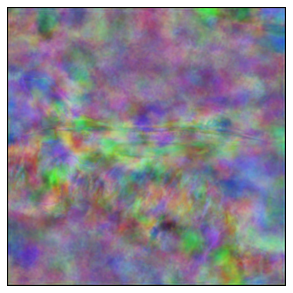

dcvx_loss:tensor(0.0013) total_loss:tensor(0.0114)405171   PSRN_gt: 25.818622 PSNR_gt_sm: 24.041940 


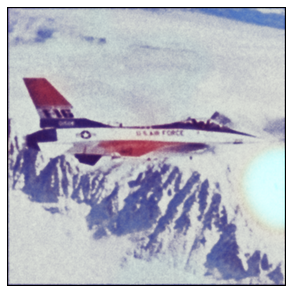

dcvx_loss:tensor(0.0013) total_loss:tensor(0.0101)942749   PSRN_gt: 27.952626 PSNR_gt_sm: 26.581929 


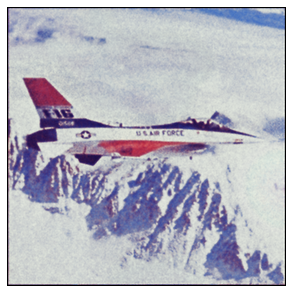

dcvx_loss:tensor(0.0013) total_loss:tensor(0.0094)257854   PSRN_gt: 28.776060 PSNR_gt_sm: 28.173927 


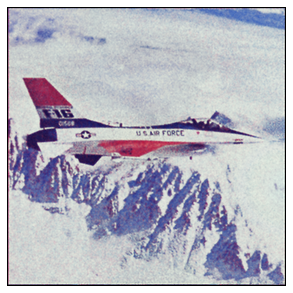

Elapsed time is 66.07366824150085 seconds.isy: 20.524822   PSRN_gt: 28.768018 PSNR_gt_sm: 29.068483 
66.07366824150085


In [8]:
# net_input_saved = net_input.detach().clone()
# noise = net_input.detach().clone()
out_avg = img_noisy_torch.detach().clone() #None
last_net = None
psrn_noisy_last = 0

i = 0
show_every=50
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input,dcvx_,stop_dcvx, dcvx_coeff
    
    #if reg_noise_std > 0:net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    #out_HR = net(net_input)
    #out = downsampler(out_HR)
    #print(net_input.shape)
    #print(out.shape)
    #print(img_noisy_torch.shape)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    if dcvx_ and not stop_dcvx:
        dcvx_loss = dcvx(parameters)*dcvx_coeff
        if i%50==0:
            print("dcvx_loss:"+str(dcvx_loss.data.cpu())+ " total_loss:"+str(total_loss.data.cpu()))
        if dcvx_loss.data.cpu()> (total_loss.data.cpu()*2):
            dcvx_coeff = dcvx_coeff*0.25
            #stop_dcvx = 1
        total_loss += dcvx_loss
            
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        #plot_image_grid([np.clip(out_np, 0, 1), np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -0.5: 
            #print('Falling back to previous checkpoint.')
            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss
OPT_OVER = 'net,input'
gauss = tgm.image.GaussianBlur((5, 5), (3.5, 3.5))
net_input = gauss(net_input_saved)  # 2x4x5x5
net_input.requires_grad=True
p = get_params(OPT_OVER, net, net_input)
num_iter = 301
tic()
optimize(OPTIMIZER, p, closure, LR, num_iter)
duration=toc()
duration_1stage=duration /num_iter
print(duration)

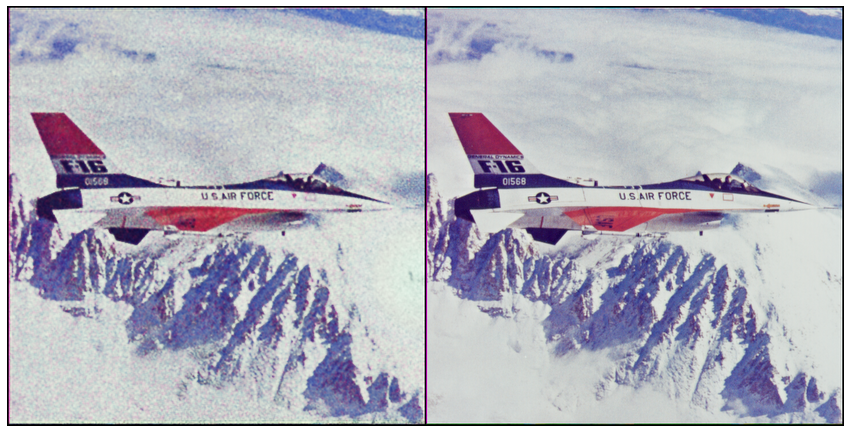

In [9]:

out_np = torch_to_np( net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

In [10]:
import pickle as pkl
if fname == 'data/denoising/snail.jpg':
    pklname='denoising_snail.pkl'
else:
    pklname='denoising_ft16_dnf.pkl'
pkl.dump([np.clip(out_np, 0, 1), img_np],open(pklname,'wb'))